------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused.

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.10.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [ ]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [ ]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2023-11-09 10:24:10--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.2’

sent_lexicon.2      100%[===================>] 647.05K  --.-KB/s    in 0.05s   

2023-11-09 10:24:10 (11.9 MB/s) - ‘sent_lexicon.2’ saved [662577/662577]

--2023-11-09 10:24:10--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercont

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [ ]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [ ]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [ ]:
def make_lexicon(weighted=False):
    """
    Create a lexicon from a file containing sentiment data.

    This function reads a text file named "sent_lexicon" and extracts word-sentiment pairs to create a lexicon
    that associates words with their corresponding sentiments. Optionally, it can include word magnitudes in the lexicon if
    the 'weighted' parameter is set to True.

    Parameters:
    weighted (bool, optional): If True, include word magnitudes along with sentiments in the lexicon.

    Returns:
    dict: A dictionary where keys are words, and values are sentiment labels (e.g., 'positive', 'negative').
    If 'weighted' is True, the values are lists containing magnitude and sentiment, e.g., ['magnitude', 'positive'].

    Example:
    If "sent_lexicon" contains the following lines:
    "type=weak word=amazing sentiment=positive"
    "type=strong word=terrible sentiment=negative"

    If 'weighted' is set to False, the resulting lexicon will be:
    {
        "amazing": "positive",
        "terrible": "negative"
    }

    If 'weighted' is set to True, the resulting lexicon will be:
    {
        "amazing": ['weaksubj', "positive"],
        "terrible": ['strongsubj', "negative"]
    }
    """
    lexicon = {}
    with open("sent_lexicon", mode="r", encoding="utf-8") as f:
      for line in f:
          parts = line.strip().split()
          magnitude = parts[0].split('=')[1]
          word = parts[2].split('=')[1]
          sentiment = parts[5].split('=')[1]

          if weighted:
            lexicon[word] = [magnitude, sentiment]
          else:
            lexicon[word] = sentiment
      return lexicon

In [ ]:
def classify_review(review, lexicon, weighted=False, threshold=8):
    """
    Classify a review as positive or negative based on a lexicon.

    This function takes a review as input and classifies it as 'POS' (positive) or 'NEG' (negative) based on the provided lexicon.
    Optionally, it supports weighting the sentiment based on a magnitude factor and a specified ratio for the binary score threshold.

    Parameters:
    review (str): The input review to be classified.
    lexicon (dict): A dictionary where keys are words, and values are sentiment labels, including optional magnitude information.
    weighted (bool, optional): If True, the sentiment scoring considers the magnitude of subjectivity (default: False).
    ratio (float, optional): A positive real number to adjust the binary score threshold (default: 1).

    Returns:
    str: 'POS' if the review is classified as positive, 'NEG' otherwise.

    The function tokenizes the input review into words and calculates a binary score based on the lexicon. If 'weighted' is True, the sentiment scoring also considers the magnitude factor. The final classification is based on comparing the binary score to a threshold defined by the 'ratio' parameter.
    """
    # Tokenize the document into words
    words = review.split()
    sbinary = 0
    # Calculate the binary score based on the lexicon
    for word in words:
      if weighted is False:
        sentiment = lexicon.get(word)
        if sentiment == "positive":
          sbinary += 1
        elif sentiment == "negative":
          sbinary -= 1
      else:
        sentiment = lexicon.get(word)[1] if lexicon.get(word) is not None else None
        magnitude = lexicon.get(word)[0] if lexicon.get(word) is not None else None
        if sentiment == "positive":
          sbinary += 1 if magnitude == "weaksubj" else 2 if magnitude == "strongsubj" else 0
        elif sentiment == "negative":
          sbinary -= 1 if magnitude == "weaksubj" else 2 if magnitude == "strongsubj" else 0

    if sbinary > threshold:
        return 'POS'
    else:
        return 'NEG'

In [ ]:
def full_sentence(s):
    """
    Construct a full sentence from a list of tokens.

    This function takes a list of tokens, where each token is represented as a tuple (token, pos_tag), and constructs a full
    sentence by joining the tokens with spaces.

    Parameters:
    s (list): A list of tokens, where each token is a tuple (token, pos_tag), and the second element of the tuple is ignored.

    Returns:
    str: A string representing the full sentence constructed by joining the tokens with spaces.
    """
    return " ".join("%s" % token for token, _ in s)

In [ ]:
def build_document(review):
  """
    Build a document by combining sub-reviews from a review.

    This function takes a review, which is typically a dictionary with a "content" key containing a list of sub-reviews.
    It constructs a single document by joining the sub-reviews with spaces.

    Parameters:
    review (dict): A dictionary containing sub-reviews under the "content" key.

    Returns:
    str: A string representing the document created by joining the sub-reviews.
  """
  document = [full_sentence(sub_review) for sub_review in review["content"]]
  joined_document = ' '.join(document)
  return joined_document

In [ ]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
lexicon = make_lexicon(weighted=False)

token_results = []

for review in reviews:
  document = build_document(review) # Combine all the sub-reviews together in a string

  true_sentiment = review["sentiment"] # Get true sentiment
  predict_sentiment = classify_review(document, lexicon) # Make a prediciton

  token_results.append(1 if true_sentiment == predict_sentiment else 0) # If prediction is correct add 1

token_accuracy = sum(token_results)/len(token_results)
print("Accuracy: %0.3f" % token_accuracy)

Accuracy: 0.679


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [ ]:
def ratio_imbalence(lexicon):
  """
    Calculate the ratio of strong subjective words associated with positive sentiment
    to strong subjective words associated with negative sentiment in a sentiment lexicon.

    This function takes a sentiment lexicon as input and calculates the ratio of strong subjective words associated
    with positive sentiment to strong subjective words associated with negative sentiment.

    The idea is the following, since a strong magnitude is twice as important as a weak one, if more of them are positive
    then negative (or vice-versa) we want to take this into account by mutiplying this ratio by the threshold.

    Parameters:
    lexicon (dict): A dictionary where keys are words, and values are sentiment labels.

    Returns:
    float: The ratio of strong subjective words with positive sentiment to strong subjective words with negative sentiment.
  """
  get_all_values = np.array(list(lexicon.values()))
  amount_strong_neg = sum(1 for value in get_all_values if 'strongsubj' in value and 'negative' in value)
  amount_strong_pos = sum(1 for value in get_all_values if 'strongsubj' in value and 'positive' in value)
  return amount_strong_pos, amount_strong_neg

In [ ]:
lexicon = make_lexicon(weighted=True)

amount_strong_pos, amount_strong_neg = ratio_imbalence(lexicon)
print("The total amount of strong positive words", amount_strong_pos)
print("The total amount of strong negative words", amount_strong_neg)
print("As a result, since there is a", amount_strong_pos/amount_strong_neg, "higher positive ratio we can higher the threshold to 9")
magnitude_results = []

for review in reviews:
  document = build_document(review) # Combine all the sub-reviews together in a string

  true_sentiment = review["sentiment"] # Get true sentiment
  predict_sentiment = classify_review(document, lexicon, weighted=True, threshold=9)  # Make a prediciton

  magnitude_results.append(1 if true_sentiment == predict_sentiment else 0) # If prediction is correct add 1

magnitude_accuracy = sum(magnitude_results)/len(magnitude_results)
print("Accuracy: %0.4f" % magnitude_accuracy)

The total amount of strong positive words 1470
The total amount of strong negative words 3061
As a result, since there is a 0.48023521724926493 higher positive ratio we can higher the threshold to 9
Accuracy: 0.6890


#### (Q.1.3) Make a barplot of the two results (0.5pt)

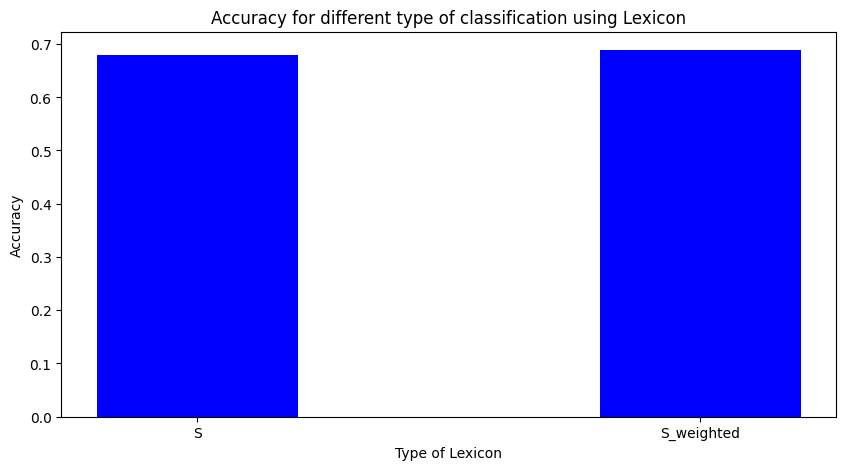

In [ ]:
# creating the dataset
data = {'S':token_accuracy, 'S_weighted':magnitude_accuracy}
types = list(data.keys())
accuracies = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(types, accuracies, color ='blue',
        width = 0.4)

plt.xlabel("Type of Lexicon")
plt.ylabel("Accuracy")
plt.title("Accuracy for different type of classification using Lexicon")
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

The threshold for classifying document sentiment is initially set at 8. However, this threshold is subject to adjustment based on the document's length. The underlying logic is that for longer documents, the threshold is increased because a greater length may indicate the presence of more positive words, making the sentiment classification more context-aware.

In [ ]:
# The idea is the following, we first calculate the average length of reviews.
# Then for each review we take the it's length and use it as a ratio (so if the length is longer we increase the amount of positives required)
lexicon = make_lexicon(weighted=False)

results = []
average_len_doc = sum(len(build_document(review).split()) for review in reviews) / len(reviews) # Get the average length of document

for review in reviews:
  document = build_document(review) # Combine all the sub-reviews together in a string

  true_sentiment = review["sentiment"] # Get true sentiment
  predict_sentiment = classify_review(document, lexicon, weighted=False, threshold=9 * len(document)/average_len_doc)  # Make a prediciton

  results.append(1 if true_sentiment == predict_sentiment else 0) # If prediction is correct add 1

results = sum(results)/len(results)
print("Accuracy: %0.4f" % magnitude_accuracy)

Accuracy: 0.6890


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

The problem with skipping words only for one class (case 2) in the test dataset is that it can lead to biased and inaccurate classification results. Since the dataset is already imbalenced (as mentioned previosly), it is very probable that a word in in the positive class but not the negative one, therefore it is very likely that those words would also lead to a 0 probability.  

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class NaiveBayesClassifier:
    def __init__(self, k=1):
        """
        Initialize a Naive Bayes Classifier with Laplace smoothing.

        Parameters:
        k (int): The Laplace smoothing constant (default is 1).

        This class initializes a Naive Bayes Classifier with Laplace smoothing.
        Laplace smoothing is used to avoid zero probabilities and provide more robust classification.
        """
        self.doc_counter = Counter()
        self.token_counter = {'POS': Counter(), 'NEG': Counter()}
        self.total_tokens = {'POS': 0, 'NEG': 0}
        self.k = k

    def fit(self, reviews):
        """
        Fit the Naive Bayes Classifier to a list of reviews.

        Parameters:
        reviews (list): A list of reviews, each containing 'sentiment' and 'content' information.

        This method calculates and stores prior and conditional probabilities for the classifier based on the provided reviews.
        """

        # Iterate over each review in the provided list of reviews.
        for r in reviews:
            sentiment = r['sentiment']  # Extract the sentiment label from the review.
            self.doc_counter[sentiment] += 1  # Update the document count for the respective sentiment.

            # Iterate over each sentence in the review's content.
            for sentence in r['content']:
                if len(sentence) == 0:
                    continue  # Skip empty sentences.

                # Iterate over each token data (word) in the sentence.
                for token_data in sentence:
                    tokens = [token.lower() for token in token_data]  # Convert tokens to lowercase.

                    if len(tokens[:-1]) == 1:
                        self.token_counter[sentiment][tokens[0]] += 1  # Count single tokens.
                    else:
                        self.token_counter[sentiment][tuple(tokens[:-1])] += 1  # Count n-grams (tuples).

        # Calculate total token counts for both positive (POS) and negative (NEG) classes.
        for c_class in ["POS", "NEG"]:
            self.total_tokens[c_class] = sum(self.token_counter[c_class].values()) + len(self.token_counter[c_class]) * self.k


    def predict(self, content):
        """
        Predict the sentiment of content using the Naive Bayes Classifier.

        Parameters:
        content (list): A list of sentences, each containing tokens to be classified.

        Returns:
        str: The predicted sentiment label ('POS' for positive or 'NEG' for negative).

        This method predicts the sentiment of content based on the trained Naive Bayes Classifier with Laplace smoothing.
        It calculates posterior probabilities for both 'POS' and 'NEG' classes and assigns the label with the higher probability as the predicted sentiment.
        """
        posterior = {}
        for c_class in ["POS", "NEG"]:
            p = self.doc_counter[c_class] / sum(self.doc_counter.values())
            posterior[c_class] = np.log(p)  # Calculate the log-prior probability for the class.

            for sentence in content:
                if len(sentence) == 0:  # Skip if the sentence is empty.
                    continue

                for token_data in sentence:
                    tokens = [token.lower() for token in token_data]

                    if len(sentence[0]) == 2:
                        final_tokens = tokens[0]
                    else:
                        final_tokens = tuple(tokens[:-1])  # Extract the tokens if n-grams.

                    if all(final_tokens in value for value in self.token_counter.values()):  # Check if token is in both classes.
                        token_prob = (self.token_counter[c_class][final_tokens] + self.k) / self.total_tokens[c_class]  # Calculate token probability.
                        posterior[c_class] += np.log(token_prob)  # Update the log-posterior probability for the class.

        return max(posterior, key=posterior.get)  # Return the class label with the highest log-posterior probability.

NB_classifier = NaiveBayesClassifier(k=0)
NB_classifier.fit(reviews[:900] + reviews[1000:1900])
test_reviews = reviews[900:1000] + reviews[1900:]
NB_results = [int(NB_classifier.predict(r['content']) == r['sentiment']) for r in test_reviews]
NB_accuracy = sum(NB_results) / len(NB_results)
print(f"Naive Bayes accuracy: {NB_accuracy:.2f}")

Naive Bayes accuracy: 0.82


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In a situation where 90% of the data instances are positive movie reviews, accuracy alone may not be a suitable evaluation metric. This imbalance can lead to artificially high accuracy, making it misleading. As a classifier that only predicts "Positive" would get 0.9% accuracy.

In [ ]:
NB_classifier = NaiveBayesClassifier(k=0)
NB_classifier.fit(reviews[:90] + reviews[1000:1900])
test_reviews = reviews[900:910] + reviews[1900:]
NB_results = [int(NB_classifier.predict(r['content']) == r['sentiment']) for r in test_reviews]
NB_accuracy = sum(NB_results) / len(NB_results)
print(f"Naive Bayes accuracy: {NB_accuracy:.2f}")

Naive Bayes accuracy: 0.60


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [ ]:
NB_classifier = NaiveBayesClassifier(k=1)
NB_classifier.fit(reviews[:900] + reviews[1000:1900])
test_reviews = reviews[900:1000] + reviews[1900:]
NB_results = [int(NB_classifier.predict(r['content']) == r['sentiment']) for r in test_reviews]
NB_accuracy = sum(NB_results) / len(NB_results)
print(f"Naive Bayes accuracy: {NB_accuracy:.2f}")

Naive Bayes accuracy: 0.83


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
k = 10  # Number of folds
accuracies = []

# Perform k-fold cross-validation
for i in range(k):
    # Split data into training and test sets
    train_reviews = [r for j, r in enumerate(reviews) if j % k != i]
    test_reviews = [r for j, r in enumerate(reviews) if j % k == i]

    NB = NaiveBayesClassifier()
    NB.fit(train_reviews)

    # Calculate accuracy for the test set
    results = [int(NB.predict(r['content']) == r['sentiment']) for r in test_reviews]
    accuracy = sum(results) / len(results)
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print("Overall accuracies:", accuracies, "with average:", average_accuracy)

Overall accuracies: [0.775, 0.825, 0.81, 0.855, 0.765, 0.855, 0.825, 0.79, 0.82, 0.805] with average: 0.8125


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [ ]:
print(sum((accuracies - average_accuracy)**2) / len(accuracies))

0.0008212499999999988


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
from nltk.stem.porter import *
import copy
stemmer = PorterStemmer()

stemsentence = copy.deepcopy(reviews)
for i, review in enumerate(reviews):
  for j, sentences in enumerate(review["content"]):
    for k, sentence in enumerate(sentences):
      for l, words in enumerate(sentence):
        stemsentence[i]["content"][j][k][l] = stemmer.stem(words)

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [ ]:
k = 10  # Number of folds
accuracies = []

# Perform k-fold cross-validation
for i in range(k):
    # Split data into training and test sets
    train_reviews = [r for j, r in enumerate(stemsentence) if j % k != i]
    test_reviews = [r for j, r in enumerate(stemsentence) if j % k == i]

    NB = NaiveBayesClassifier()
    NB.fit(train_reviews)

    # Calculate accuracy for the test set
    results = [int(NB.predict(r['content']) == r['sentiment']) for r in test_reviews]
    accuracy = sum(results) / len(results)
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print("Overall accuracies:", accuracies, "with average:", average_accuracy)

Overall accuracies: [0.78, 0.83, 0.805, 0.86, 0.785, 0.85, 0.82, 0.78, 0.84, 0.81] with average: 0.8160000000000001


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
def vocabulary_size(reviews):
    """
    Calculate the vocabulary size of a list of reviews.

    Parameters:
    reviews (list): A list of reviews

    Returns:
    set: A set containing unique words from the reviews.

    This function calculates the vocabulary size of a list of reviews by extracting unique words from the review content.
    """

    set_words = set()  # Initialize an empty set to store unique words.

    # Iterate over each review in the list.
    for review in reviews:
        # Iterate over each sentence in the review's content.
        for sentences in review["content"]:
            # Iterate over each sentence in the sentences.
            for sentence in sentences:
                  if len(sentence[:-1])==1:
                    set_words.add(sentence[0])  # Add the word to the set of unique words.
                  else: # This is for a later question with the n-grams (in this scenario we want to compares the n-grams)
                    set_words.add(tuple(sentence[:-1]))

    return set_words  # Return the set of unique words, representing the vocabulary size.


In [ ]:
set_words_1grams = vocabulary_size(reviews)
print("Size of the vocabulary without stemming:", len(set_words_1grams))

set_words = vocabulary_size(stemsentence) # Using the stem vocabulary from Q.2.6
print("Size of the vocabulary with stemming:", len(set_words))

Size of the vocabulary without stemming: 55384
Size of the vocabulary with stemming: 34200


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
def make_ngrams(reviews, amount_ngrams):
    """
    Create n-grams from the content of reviews.

    Parameters:
    reviews (list): A list of review dictionaries, where each dictionary contains content to create n-grams from.
    amount_ngrams (int): The number of n-grams to generate.

    Returns:
    list: A list of review dictionaries with n-grams added to their content.

    This function takes a list of review dictionaries and generates n-grams from the content of each review's sentences.
    It adds the n-grams to the content and returns a new list of review dictionaries with n-grams included.
    """

    ngrams_list = copy.deepcopy(reviews)  # Create a deep copy of the original reviews list.

    # Iterate over each review in the list.
    for i, review in enumerate(reviews):
        # Iterate over each sentence in the review's content.
        for j, sentence in enumerate(review["content"]):
            joined_sent = full_sentence(sentence)  # Join the tokens in the sentence into a single string.

            ngram = list(ngrams(joined_sent.split(), amount_ngrams))  # Generate n-grams from the sentence tokens.

            # Use list comprehension to generate n-grams and append underscores (useless character to match adverb token).
            ngrams_list[i]["content"][j] = [list(ngram_el) + ["_"] for ngram_el in ngram]

    return ngrams_list  # Return the list of review dictionaries with n-grams added to their content.


In [ ]:
bigrams = make_ngrams(reviews, amount_ngrams=2)

NB_classifier = NaiveBayesClassifier(k=1)
NB_classifier.fit(bigrams[:900] + reviews[:900] + bigrams[1000:1900] + reviews[1000:1900])
test_reviews = reviews[900:1000] + reviews[1900:] + bigrams[900:1000] + bigrams[1900:]
NB_results = [int(NB_classifier.predict(r['content']) == r['sentiment']) for r in test_reviews]
NB_accuracy = sum(NB_results) / len(NB_results)
print(f"Naive Bayes accuracy: {NB_accuracy:.2f}")

Naive Bayes accuracy: 0.82


In [ ]:
trigrams = make_ngrams(reviews, amount_ngrams=3)

NB_classifier = NaiveBayesClassifier(k=1)
NB_classifier.fit(trigrams[:900]+ reviews[:900] + bigrams[:900] + reviews[1000:1900] + bigrams[1000:1900] + trigrams[1000:1900])
test_reviews = reviews[900:1000] + reviews[1900:] + bigrams[900:1000] + bigrams[1900:] + trigrams[900:1000] + trigrams[1900:]
NB_results = [int(NB_classifier.predict(r['content']) == r['sentiment']) for r in test_reviews]
NB_accuracy = sum(NB_results) / len(NB_results)
print(f"Naive Bayes accuracy: {NB_accuracy:.2f}")

Naive Bayes accuracy: 0.80



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


As the value of "n" in n-grams increases, the number of unique n-grams and features grows exponentially. This growth is a result of the increasing number of possible combinations of "n" consecutive words, which expands every time we move from n-grams to (n+1)-grams.

In more precise terms, for a vocabulary size of "V," the number of possible (n+1)-grams is determined by V*(n+1), and this growth follows an exponential pattern.

Size of the vocabulary for bigrams: 477485
Size of the vocabulary for trigrams: 986354


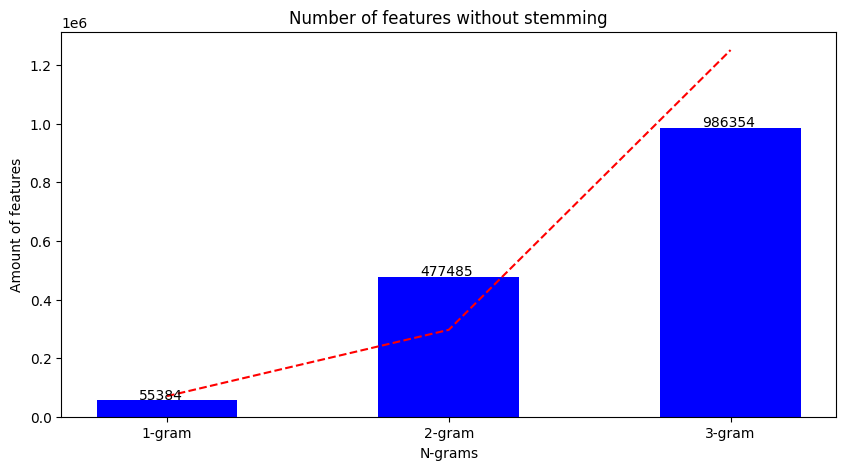

In [ ]:
set_words_bigrams = vocabulary_size(bigrams)
print("Size of the vocabulary for bigrams:", len(set_words_bigrams))

set_words_trigrams = vocabulary_size(trigrams)
print("Size of the vocabulary for trigrams:", len(set_words_trigrams))

plt.figure(figsize=(10, 5))
plt.bar(["1-gram", "2-gram", "3-gram"], [len(set_words_1grams), len(set_words_bigrams), len(set_words_trigrams)], width=0.5, color="blue")

for i, v in enumerate([len(set_words_1grams), len(set_words_bigrams), len(set_words_trigrams)]):
  plt.text(i-0.1, v+ 5000, str(v))
plt.ylabel("Amount of features")
plt.xlabel("N-grams")
plt.title("Number of features without stemming")

x= np.arange(3)
y = [len(set_words_1grams), len(set_words_bigrams), len(set_words_trigrams)]
p = np.polyfit(x, np.log(y), 1)
plt.plot(x, np.exp(p[1]) * np.exp(p[0] * x), '--r')
plt.show()

# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
# YOUR CODE HERE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

#--------------------- HELPER FUNCTIONS ---------------------
def create_folds(data, n_folds=10):
    """
    Create folds using robin-round style.

    Parameters:
    data (list): Reviews containing the X_train and y_train.
    n_folds (int): number of folds to split the data.

    Returns:
    folds (list): data splitted in n_folds.
    """
    folds = []
    fold_indices = []
    n_data = len(data)

    # computes indices using Round Robbin fashion
    '''
    fold: 0
    [0, 10, 20, 30, 40, 50, 60, 70, ..., 960, 970, 980, 990]
    fold: 1
    [1, 11, 21, 31, 41, 51, 61, 71, ..., 961, 971, 981, 991]
    fold: 2
    [2, 12, 22, 32, 42, 52, 62, 72, ..., 962, 972, 982, 992]
    fold: 3
    [3, 13, 23, 33, 43, 53, 63, 73, ..., 963, 973, 983, 993]
    fold: 4
    [4, 14, 24, 34, ...
    '''
    # create indices for folds
    for n in range(n_folds):
        fold_indices.append(list(range(n, n_data, n_folds)))

    # fill folds w/ corresponding indices
    for cur_fold_indices in fold_indices:
        folds.append([data[i] for i in cur_fold_indices])

    return folds

def split_data(cur_fold, folds):
    """
    Extract from folds the training and testing data for current fold.

    Parameters:
    cur_fold (int): current fold number.
    folds (list): data splitted in n_folds.

    Returns:
    lists: 1 out 10 folds for testing, remaining for training
          - X_train : token + tag
          - X_test  : token + tag
          - y_train : 'NEG', 'POS'
          - y_test  : 'NEG', 'POS'
    """
    # get train & test data for current fold
    train, test = [], []
    for j, fold in enumerate(folds):
      if j == cur_fold:
          test.extend(fold)
      else:
          train.extend(fold)

    # extract content and sentiment from reviews
    X_train = [review['content'] for review in train]
    y_train = [review['sentiment'] for review in train]

    X_test = [review['content'] for review in test]
    y_test = [review['sentiment'] for review in test]

    return X_train, y_train, X_test, y_test

def get_features(X_fold, pos_tags=False, closed_classes=False):
    """
    Extract features accroding to methods ( POST Tagging, Closed-classes or None) from data.

    Parameters:
    X_fold (list): training data containing the word and tag.
    pos_tags (bool): adds the tag to the features.
    closed_classes (bool): keep data only nouns, verbs, adjectives, and adverbs.

    Returns:
    list: reviews presented as sentences w/ lowered words + tag (if applicable)
    """
    text = []
    for i, review in enumerate(X_fold):
      acc_sentences = ""
      for sentence in review:
        if len(sentence)==1:
          continue

        for word, tag in sentence:
          word = word.lower()

          # just add the word
          if not (pos_tags or closed_classes):
            acc_sentences += word + " "

          # adding tag
          if pos_tags:
            acc_sentences += word + "_" + tag + " "

          # keep only nouns, verbs, adjectives, and adverbs
          if closed_classes:
            if (tag.startswith('NN') or tag.startswith('VB') or
                tag.startswith('JJ') or tag.startswith('RB')):
              acc_sentences += word + "_" + tag + " "
            else:
              continue

      text.append(acc_sentences)
    return text


def train_SVM(clf, X_train, y_train):
    """
    Trains a SVM model classifier.

    Parameters:
    X_train (list): training data with sentences having lowered-words (+ tag).
    y_train (list): labels POS or NEG.

    Returns:
    object: model trained
    """
    # train model
    clf.fit(X_train, y_train)
    return clf

def get_acc(y_preds, y_test):
    """
    Calcualted accuracies for current fold, compares truth to predicted labesl.

    Parameters:
    y_preds (list): predicted labels.
    y_test  (list): truth labels POS or NEG.

    Returns:
    float: number indicating the accuracy of the model
    """
    acc = 0.0
    for i, y_pred in enumerate(y_preds):
      # if same label increase accumulator
      if y_pred == y_test[i]:
        acc += 1
    return (acc/len(y_test))


In [ ]:
# YOUR CODE HERE
from sklearn.svm import LinearSVC
def cros_val_SVM(reviews, n_folds=10, pos_tags=False, closed_class=False, print_fold_acc=False):
  """
  Do cross validation w/ SVM as classifier on reviews data.

  Parameters:
  reviews (list): Reviews containing the X_train and y_train.
  n_folds (int): number of folds.
  pos_tags (bool): adds the tag to the features.
  closed_classes (bool): keep data only nouns, verbs, adjectives, and adverbs.
  print_fold_acc (bool): print per each fold the model accuracy

  Returns:
  float: number indicating the mean accuracy of the model
  """

  # convert text to numerical features for SVM
  # https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html
  vectorizer = TfidfVectorizer(stop_words='english')

  # Create 10 folds
  folds = create_folds(reviews, n_folds=n_folds)
  n_folds = len(folds)

  # mean accuracy of the model
  mean_accuracy = 0.0

  # creates SVM clasifier
  clf = LinearSVC()

  # Train and eval each fold
  print(f'--- Starting SVM Cross Validation ---')
  if pos_tags:
    print("-- Using: POST-Tagging")
  if closed_class:
    print("-- Using: closed_class")

  for cur_fold in range(n_folds):
    # split the data for training and evaluation
    '''
    X_train[0], X_train[1]
    len(X_train[0]): 11 sentences -> [[['Damn', 'JJ'], ['that', 'IN'],..]
    len(X_train[1]): 26 sentences -> [[['Janeane', 'NNP'], ['Garofalo', 'NNP'],..]

    y_train
    ['NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG'...
    '''
    X_train, y_train, X_test, y_test = split_data(cur_fold, folds)

    # Q 3.2 & 3.3
    X_train = get_features(X_train, pos_tags, closed_class)
    X_test = get_features(X_test, pos_tags, closed_class)

    # vectorize X data for SVM
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # train classifier w/ current folds
    SVM_clf = train_SVM(clf, X_train_vec, y_train)

    # predict labels
    y_pred = SVM_clf.predict(X_test_vec)

    # calcualte acc per fold
    accuracy = get_acc(y_pred, y_test)
    if print_fold_acc:
      print(f"Accuracy of {cur_fold}-fold : {accuracy}")
    mean_accuracy += accuracy

  return mean_accuracy/n_folds


In [ ]:
mean_accuracy = cros_val_SVM(reviews, n_folds=10, print_fold_acc=False)
print(f"Mean Accuracy: {mean_accuracy}")

--- Starting SVM Cross Validation ---
Mean Accuracy: 0.8535


Comparison between 10_Cross-validation mean accuracacy results:
  - NB w/ smoothing (k=1): 0.8125
  - LinearSVM (only word): 0.8535

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# YOUR CODE HERE
mean_accuracy = cros_val_SVM(reviews, n_folds=10, pos_tags=True, print_fold_acc=False)
print(f"Mean Accuracy: {mean_accuracy}")

--- Starting SVM Cross Validation ---
-- Using: POST-Tagging
Mean Accuracy: 0.8559999999999999


*Write your answer here.*

Comparison between 10_Cross-validation mean accuracacy results:
  - NB w/ smoothing (k=1): 0.8125
  - LinearSVM (only word): 0.8535
  - LinearSVM (word + tag): 0.8559

The difference in improvement is not significant which suggest that adding POS tag does not lead to major improvements on the performance of the SVM model at clasifying reviews. A reason for this could be due to the ambuigity when tagging the word. For instance when examining the reviews we see that one review has that `['drink', 'NN']` which without context this could be a verb or a noun, here set as a noun. Another example found in our data which (Beatrice, 1990) also mentions in her paper is the word one `['one', 'CD']` which could be expressed as cardinal number or as a noun. Therefore, the presense of these ambiguities when tagging words in different contexts does not lead to significant improvements when classifing the reviews.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# (tag.startswith('NN') or tag.startswith('VB') or tag.startswith('JJ') or tag.startswith('RB'))
# NNP is also a noun, NNS is also a noun ... --> hence we use startswith
mean_accuracy = cros_val_SVM(reviews, n_folds=10, closed_class=True, print_fold_acc=False)
print(f"Mean Accuracy: {mean_accuracy}")

--- Starting SVM Cross Validation ---
-- Using: closed_class
Mean Accuracy: 0.8629999999999999


*Write your answer here.*

Comparison between 10_Cross-validation mean accuracacy results:
  - NB w/ smoothing (k=1): 0.8125
  - LinearSVM (only word): 0.8535
  - LinearSVM (word + tag): 0.8559
  - LinearSVM (word + open_class_tags): 0.8629

We see a slighly improvement as compared to previous methods. In this case, we are only conserving nouns, verbs, adjectives, and adverbs (and all its variations i.e NNP, NNS and so on) which may encompass better the sentiment of a review. Thus, conserving the open classes makes for the slight improvement which prove not to be detrimental in this context.



# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.

## Sentiment Lexicon
**Results:**
  - Sing: 0.679
  - Weights: 0.689
  - New Treshold without weights: 0.689

**Sumary:**
- Ignores the context of the word
- Not explicit way how to model strong vs weak words. A weight of 2 was chosen. When increasing this factor accuracy suffered.
- The updated threshold, when applied in conjunction with weights, does not yield substantial improvements. However, when utilized without incorporating weights, it leads to significant progress primarily attributed to the length adaptation.
- Unbalanced data can be accounted by using a different treshold value. Those methods ara data dependent.

## Naive Bayes
**Results:**
  - Vanilla: 0.82
  - 90% Unbalanced: 0.60
  - Smoothing: 0.812
  - Steeming: 0.816
  - Bigrams: 0.82
  - Trigrams: 0.80

**Sumary:**
- Words are treated independently. This means their position in a sentence is not taken into account. For unigrams this is not ideal as negation of adjectives clearly change the sentiment of the review. For bigrams and above this was benefitial
-In the case of imbalanced data, Vanilla Naive Bayes faces performance challenges as the model is predominantly exposed to one class. This lack of exposure to the minority class hinders the model's ability to adapt effectively, impacting its performance on the underrepresented class.
- To avoid features not seen in the dataset smoothing can remediate probabilities being zero
- Stemming helped with reduction of features while conserving `stem` information and slighly improving NB classifier.
- Bi and Trigrams features can encompases context information.
- Trigrams do not seem to improve our model. This could be due to adding unnecesary information which makes the classification of the review harder.

## LinearSVM
**Results:**
  - LinearSVM (only word): 0.853
  - LinearSVM (word + tag): 0.855
  - LinearSVM (word + open_class_tags): 0.862

**Sumary:**
- Better performance than NB w/ smoothing as compared to vanilla LinearSVM and improvements with tag methods
- Using POS_tagging improves our model as we are now introducing the lexical category (nouns, verbs, adjective, ..) of a word which in turn aids to the model to capture the sentiment of a review. For instance: finding happy_adj in a sentence are a direct clue for a POS sentiment.      
- Encounter problem of ambuigity when tagging words without taking into account its context, i.e `drink` as verb or as a noun.
- Open-classes can reduce the number of features while allowing for a slighlty improvement on accuracy as compared to POS_tagging (all tags). This is because closed-classes do not (generally) carry POS or NEG clues therefore by skipping these words we can save in memory thus reducing the number of features.

# Submission


In [ ]:
# Write your names and student numbers here:
# Student 1 #12345
# Danilo Toapanta #14077566
# Jort Vincenti #15209997

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.